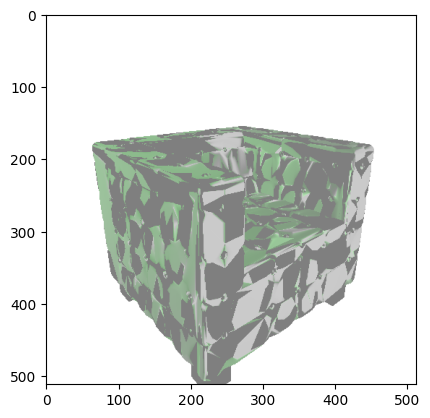

In [18]:
import torch
import matplotlib.pyplot as plt
from lib.data.preprocess_sketch import image_grid
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    HardGouraudShader,
    HardPhongShader,
    Materials,
    MeshRasterizer,
    MeshRenderer,
    PointLights,
    RasterizationSettings,
    SoftPhongShader,
    TexturesVertex,
    look_at_view_transform,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "/home/borth/sketch2shape/data/siamese_chair_medium/1b5ab441fb8e3b1b450621b513a975bb/model_normalized.obj"

# load and prepare the shapenet objects
obj = load_obj(path, load_textures=False)
verts = obj[0].to(device)
faces = obj[1].verts_idx.to(device)

# texture
verts_rgb = torch.ones_like(verts)[None]
textures = TexturesVertex(verts_features=verts_rgb)

# create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)

R, T = look_at_view_transform(1, 20, 140)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

materials = Materials(device=device, specular_color=[[0.0, 1.0, 0.0]], shininess=1)

# initilizing the rasterization
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# initilizing the lights
lights = PointLights(device=device, location=[[0, 0, 1]])

# initilizing the renderer
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings,
    ),
    shader=HardPhongShader(
        cameras=cameras,
        device=device,
        lights=lights,
        materials=materials,
    ),
)

image = renderer(mesh).cpu().numpy()[0, ..., :3]
plt.imshow(image)

In [37]:
import torch
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "/home/borth/sketch2shape/data/siamese_chair_medium/1b5ab441fb8e3b1b450621b513a975bb/model_normalized.obj"

# load and prepare the shapenet objects
obj = load_obj(path, load_textures=False)
verts = obj[0].to(device)
faces = obj[1].verts_idx.to(device)

# texture
verts_rgb = torch.ones_like(verts)[None]
textures = TexturesVertex(verts_features=verts_rgb)

# create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)

# Render the plotly figure
fig = plot_scene(dict(plot=dict(plot=mesh)))
fig.show()

In [ ]:
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj

In [22]:
import torch
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "/home/borth/sketch2shape/data/cow_mesh/cow.obj"

# load and prepare the shapenet objects
obj = load_obj(path, load_textures=False)
verts = obj[0].to(device)
faces = obj[1].verts_idx.to(device)

# texture
verts_rgb = torch.ones_like(verts)[None]
verts_rgb[:, :, :] = 0.9
textures = TexturesVertex(verts_features=verts_rgb)

# create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)

# Render the plotly figure
fig = plot_scene(dict(plot=dict(plot=mesh)))
fig.show()

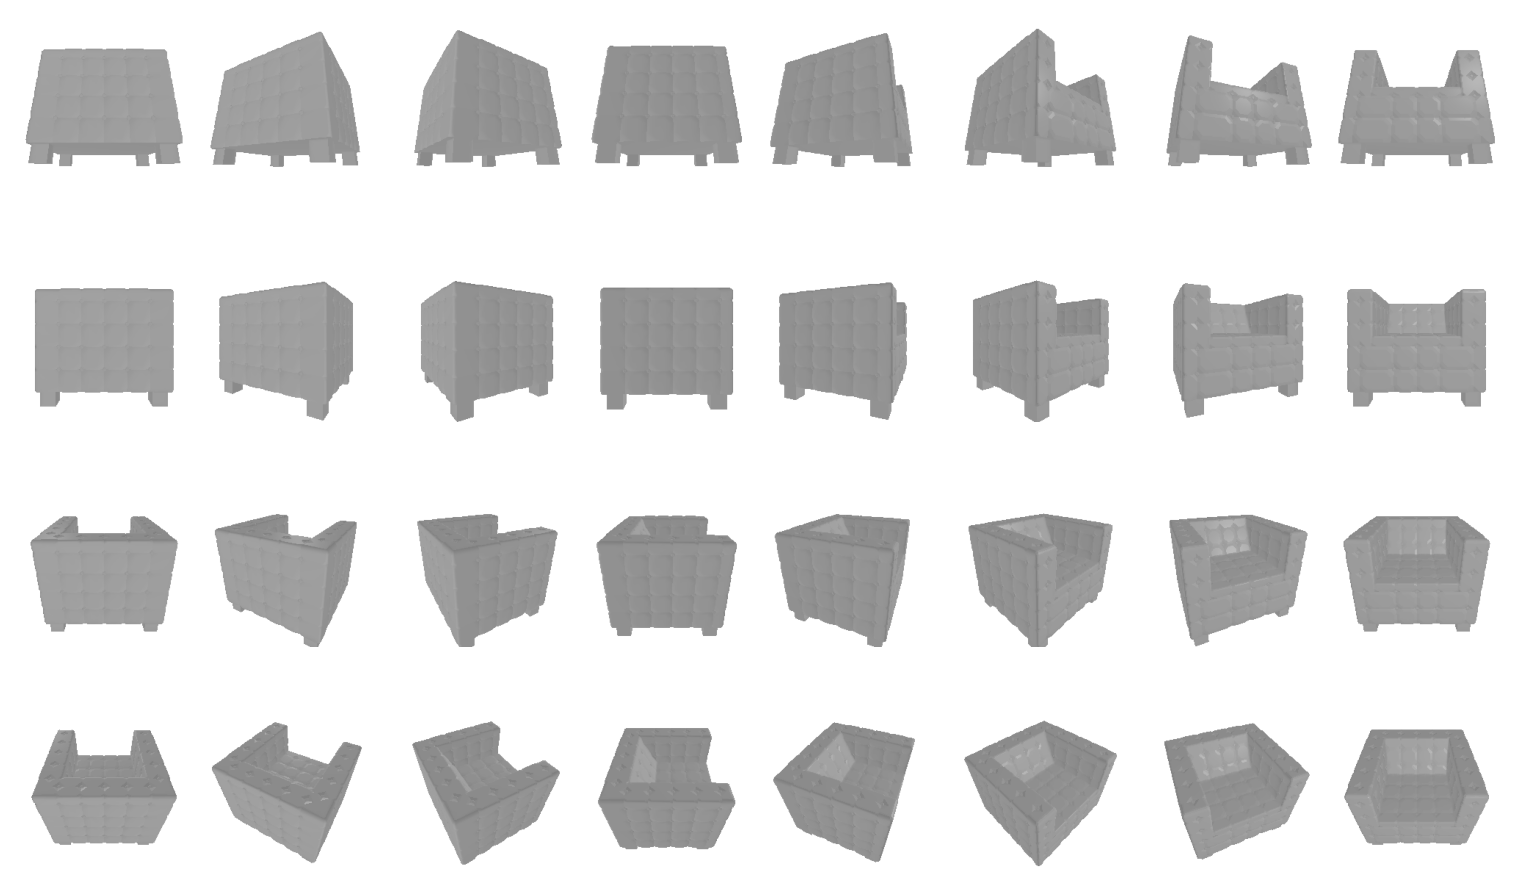

In [7]:
import open3d as o3d
import torch
import matplotlib.pyplot as plt
import numpy as np
from lib.data.preprocess_sketch import image_grid
from pytorch3d.io import load_obj
from lib.data.preprocess_sketch import cartesian_elev_azim
from open3d.utility import set_verbosity_level, VerbosityLevel
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    HardPhongShader,
    SoftPhongShader,
    HardGouraudShader,
    TexturesVertex,
    SoftGouraudShader,
    HardFlatShader,
    SoftSilhouetteShader,
    PointLights,
    DirectionalLights,
    PointLights,
    RasterizationSettings,
    FoVPerspectiveCameras,
    FoVOrthographicCameras,
    MeshRasterizer,
    MeshRenderer,
    look_at_view_transform,
)

def render_shapenet(
    path: str,
    dist: float = 1.0,
    elevs: list[int] = [0],
    azims: list[int] = [0],
    color: float = 1,
    image_size: int = 256,
    device: str = None,
):
    # settings
    set_verbosity_level(VerbosityLevel.Error)
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
   
    # load the mesh
    open3d_mesh = o3d.io.read_triangle_mesh(path)
    verts = torch.tensor(np.asarray(open3d_mesh.vertices), dtype=torch.float32).to(device)
    faces = torch.tensor(np.asarray(open3d_mesh.triangles), dtype=torch.int64).to(device)
    
    # set the texture
    verts_rgb = torch.ones_like(verts)[None]
    verts_rgb[:, :, :] = color
    textures = TexturesVertex(verts_features=verts_rgb)
    
    # create pytorch 3d mesh
    mesh = Meshes(
        verts=[verts],
        faces=[faces],
        textures=textures,
    )

    # initilizing the rasterization
    raster_settings = RasterizationSettings(
        image_size=image_size,
        blur_radius=0.0,
        faces_per_pixel=8,
    )

    # initilizing the lights
    lights = PointLights(device=device, location=[[-1, 1, -2]])

    # initilizing the renderer
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=raster_settings,
        ),
        shader=SoftPhongShader(
            device=device,
            lights=lights,
        ),
    )

    # initilize the transformation delta for the object
    # delta = ((verts.max(dim=0)[0] + verts.min(dim=0)[0]) / 2).detach().cpu()

    # loop for each camara position
    images = []
    for elev, azim in zip(elevs, azims):
        R, T = look_at_view_transform(dist=1, elev=elev, azim=azim)
        # T[0] -= delta
        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
        image = renderer(mesh, cameras=cameras).cpu().numpy()[0, ..., :3]
        images.append((image * 255).astype(np.uint8))

    return np.stack(images, axis=0)

elev = [-22.5, 0, 22.5, 45] 
# azim = [0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180] 
azim = [0, 30, 60, 90, 112.5, 135, 157.5, 180]
# azim = [0, 30, 60, 77.0, 90, 120, 150, 180]
# azim = [0, 35, 90, 120, 180, 240, 270, 320] 
# azim = [60, 135, 180, 230, 280, 330, 360] 
elevs, azims = cartesian_elev_azim(elev=elev, azim=azim)
# path = "/home/borth/sketch2shape/data/siamese_chair_large/1fb9ffbcd38f8ba63eec26c23f5bc80b/model_normalized.obj"
# path = "/home/borth/sketch2shape/data/siamese_chair_large/1c2cad4df1697103a5139737ddc33fc8/model_normalized.obj"
path = "/home/borth/sketch2shape/data/siamese_chair_medium/1b5ab441fb8e3b1b450621b513a975bb/model_normalized.obj"
images = render_shapenet(path, elevs=elevs, azims=azims)
image_grid(images, len(elev), len(azim))

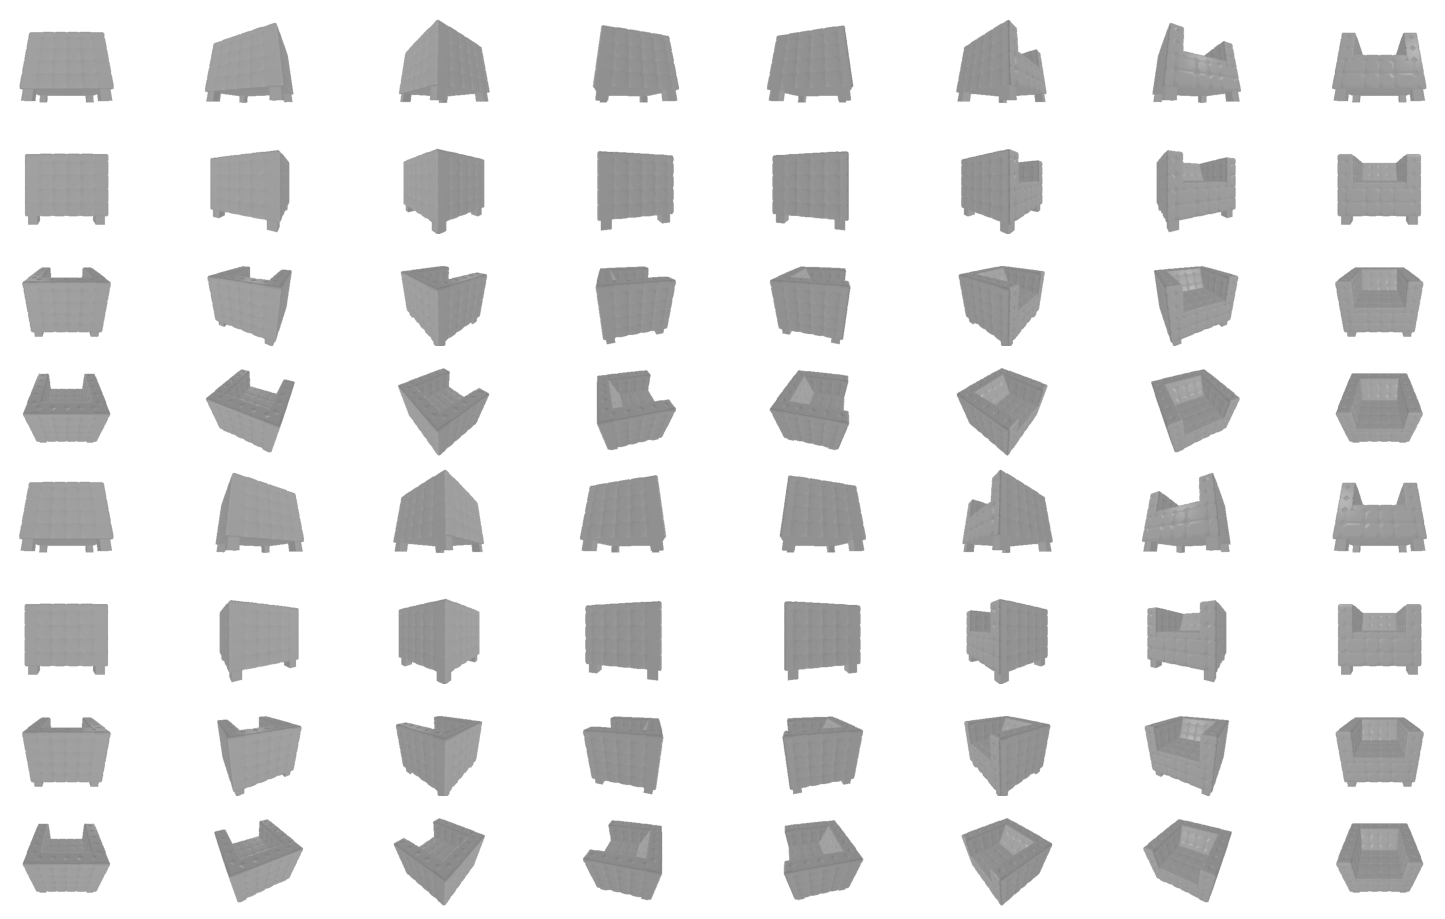

In [4]:
from torchvision.transforms import RandomHorizontalFlip
flip = RandomHorizontalFlip(1)
fimages = flip(torch.tensor(images).permute(0, 3, 1, 2))
fimages = fimages.permute(0, 2, 3, 1).numpy()
aimages = np.concatenate([images, fimages])
image_grid(aimages, len(elev) * 2, len(azim))

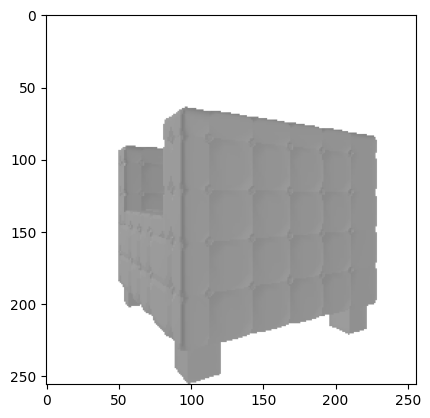

In [459]:
from torchvision.transforms import RandomHorizontalFlip
flip = RandomHorizontalFlip(0.5)
img = flip(torch.tensor(np.transpose(images[3], (2, 0, 1)))).numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

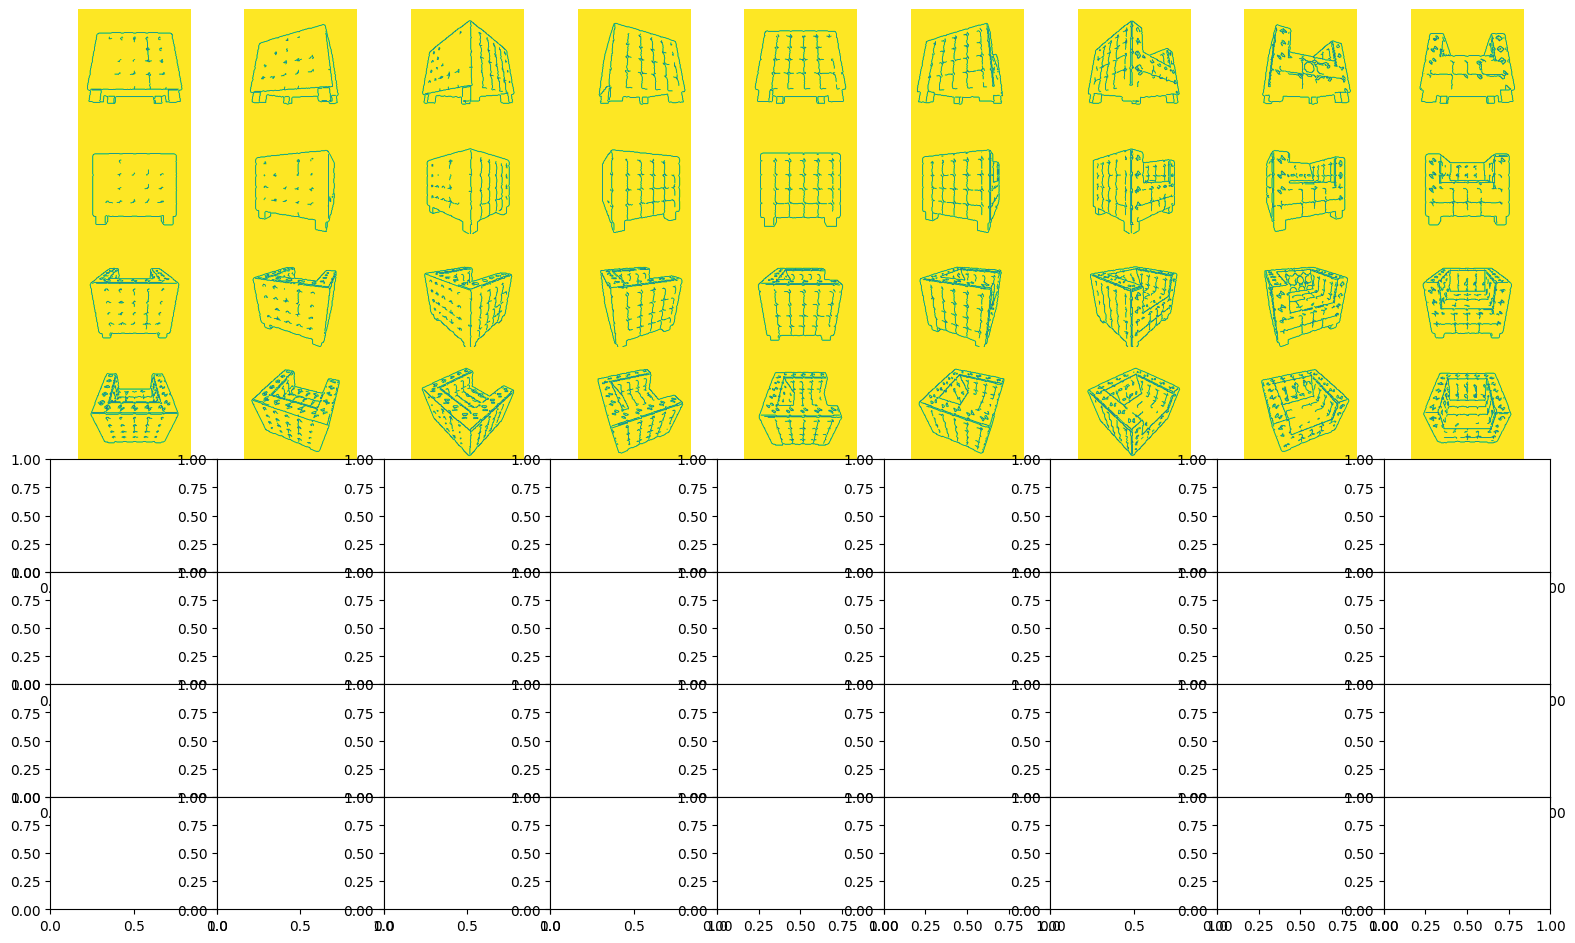

: 

In [535]:
import cv2 as cv

high_resolution = {
    "t_lower": 20,
    "t_upper": 40,
    "aperture_size": 3,
    "L2gradient": True,
}

low_resolution = {
    "t_lower": 40,
    "t_upper": 50,
    "aperture_size": 3,
    "L2gradient": True,
}
def images_to_sketch(
    images,
    t_lower: int = 150,
    t_upper: int = 250,
    aperture_size: int = 5,  # 3, 5, 7
    L2gradient: bool = False,
):
    edges = []
    for img in images:
        edge = cv.Canny(img, t_lower, t_upper, L2gradient=L2gradient)
        edge = cv.bitwise_not(edge)
        edges.append(edge)
    return np.stack(edges)


sketch = images_to_sketch(images, **high_resolution)
image_grid(sketch, len(elev) * 2, len(azim))

# plt.imshow(sketch)
# plt.show()

In [527]:
cv2.imwrite("out.jpg", sketch[0])

True

In [533]:
from PIL import Image
np.array(Image.open("out.jpg")).shape

(256, 256)

In [522]:
from torchvision.transforms import ToTensor
from torchvision.models.resnet import resnet18
model = resnet18()
# x = torch.randn(3, 128, 128)
x = ToTensor()(sketch[0])[None]
model(x)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 1, 256, 256] to have 3 channels, but got 1 channels instead

In [524]:
x.shape

torch.Size([1, 1, 256, 256])

(120, 256, 256, 3)


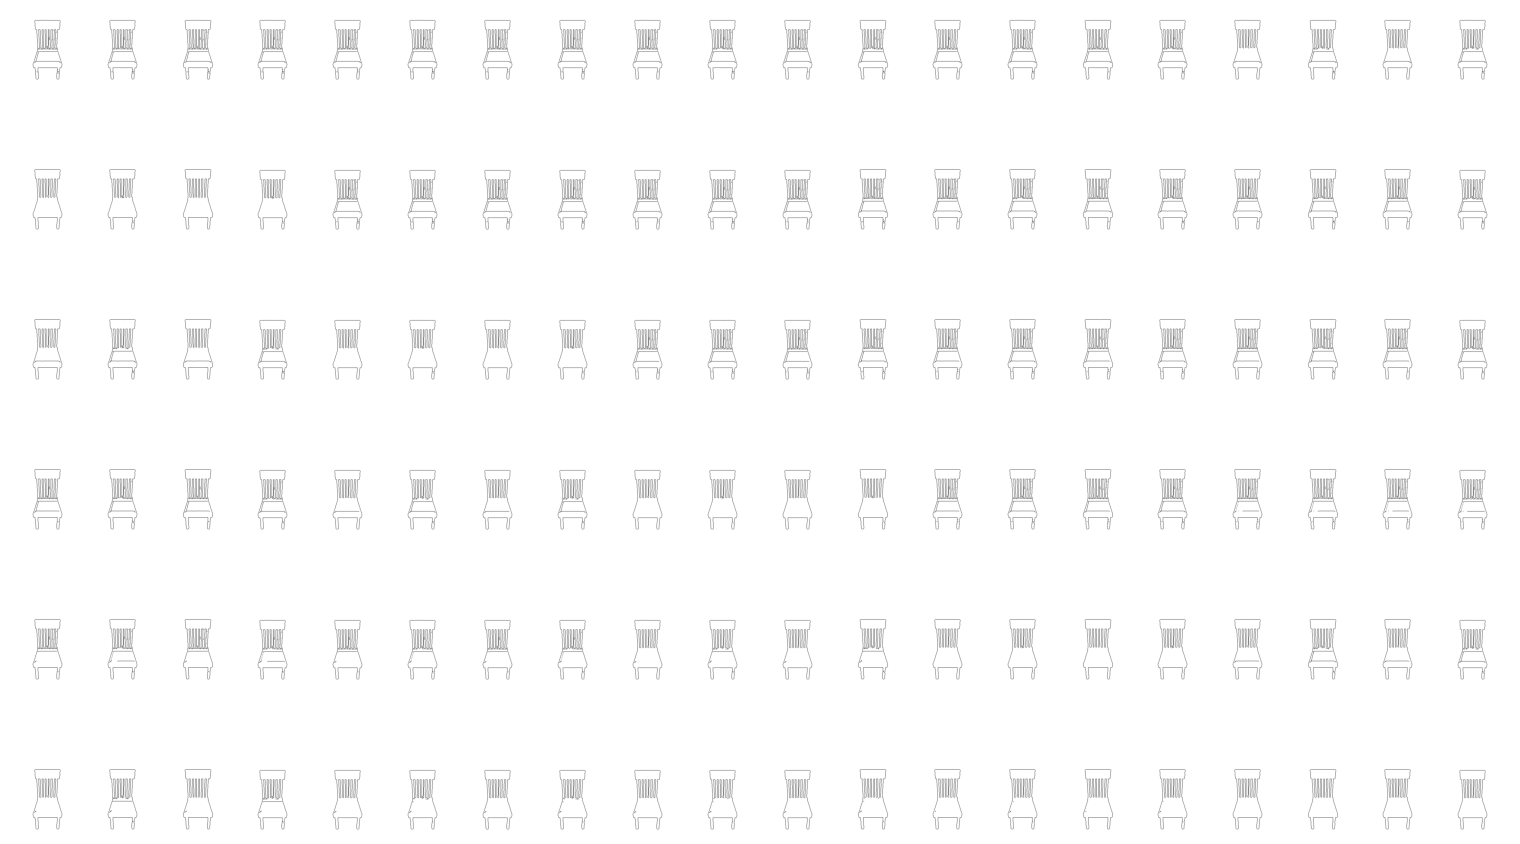

In [384]:
import cv2 as cv


def images_to_sketch(
    images,
    t_lower: int = 150,
    t_upper: int = 250,
    aperture_size: int = 5,  # 3, 5, 7
    L2gradient: bool = False,
):
    edges = []
    for img in images:
        edge = cv.Canny(img, t_lower, t_upper, L2gradient=L2gradient)
        edge = cv.bitwise_not(edge)
        edges.append(edge)
    edges = np.stack((np.stack(edges),) * 3, axis=-1)
    return edges


hparams = {
    "t_lower": [20, 30, 40, 50, 100],
    "t_upper": [40, 50, 60, 70, 100, 150],
    "aperture_size": [3, 5],
    "L2gradient": [True, False],
}


sketches = []
for t_lower in hparams["t_lower"]:
    for t_upper in hparams["t_upper"]:
        for aperture_size in hparams["aperture_size"]:
            for L2gradient in hparams["L2gradient"]:
                images = [(image * 255).astype(np.uint8)]
                sketch = image_to_sketch(
                    images,
                    t_lower=t_lower,
                    t_upper=t_upper,
                    aperture_size=aperture_size,
                    L2gradient=L2gradient,
                )[0]
                sketches.append(sketch)
sketches = np.stack(sketches)
print(sketches.shape)
image_grid(sketches, 6, 20)